# Estudo de machine learning com dados da Covid-19 utilizando o fastai.

Esse arquivo tem como objetivo documentar sobre como funcionaria um modelo de machine learning para previsão especificamente de casos da covid-19. Os dados ja estão pré-tradados em relação aos dados originais obtidos nesse [site](https://opendatasus.saude.gov.br/gl/dataset/casos-nacionais) a fim de dessobrecarregar a máquina. 

Com relação aos dados são dados do e-sus obtidos a aprtir de uma ficha que é preenchida ao se antender pacientes suspeitos de covid-19. Os dados levados em conta nesse treinamento foram: 

- Sintomas (uma lista de sintomas que o paciente apresentou)
- Idade (a data de nascimento estava faltando em boa parte dos dados, e também a data de nascimento daria a idade atual, sendo que o mais relevante é a idade que o paciente tinha no momento que ele foi atendido).
- Resultado Teste (Resultado do teste de covid-19)
- Condicoes (Doenças preexistentes no paciente)
- Sexo

Os dados originais possuem mais dados que não foram usados nesse treinamento. 

## Treinamento.

A começar a apresentar o treinamento, foram utilizadas algumas bibliotecas que são importadas a seguir e também uma função que é utilizada para padronizar as strings do campo **sintomas**.

In [ ]:
# Fastai model

from fastai.tabular.all import *
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
from tqdm.notebook import tqdm_notebook
from unidecode import unidecode


In [2]:
# Lista de funções úteis 

def std_str(s):
    return unidecode(s.lower().replace(' ', ''))

### Leitura dos csv.

Os arquivos .csv estão tratados na pasta /data. Por padrão os arquivos foram decodificados em latin-1, que normalmente é a codificação dos dados governamentais, porém alguns dados não foram decodificados corretamente, algumas outras decodificações foram testadas, como a win e utf-8, mas continuava com problemas de decodificação. Por tanto, nos campos categóricos, esses problemas foram contornados. 

In [3]:
# Lendo base de dados.
baseDados = pd.Series()   

all_files = glob.glob('./data' + '/*.csv')

for file in tqdm_notebook(all_files):
    df = pd.read_csv(file, delimiter=';', encoding='latin-1')
    baseDados = pd.concat([baseDados, df], ignore_index=True)

baseDados = baseDados.drop(['Ã¿id', 'Unnamed: 0', 0], axis=1)
baseDados.head()

/tmp/ipykernel_35988/3809777786.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  baseDados = pd.Series()


  0%|          | 0/20 [00:00<?, ?it/s]

,condicoes,idade,resultadoTeste,sexo,sintomas
0,NaN,73.0,NaN,Feminino,Outros
1,NaN,36.0,Positivo,Masculino,"Febre, Dor de Garganta, Outros"
2,NaN,34.0,Negativo,Feminino,Tosse
3,NaN,20.0,Positivo,Masculino,"Tosse, Febre, Dor de Garganta, Outros"
4,NaN,32.0,Negativo,Feminino,Outros


### Removendo linhas em que o resultado é invalido.

Esse campo é o conjunto Y do modelo e portanto é importante que contenha apenas dados coerentes e qualquer estratégia de preenchimento de dados errôneos poderia comprometer o modelo de treinamento. 

In [5]:

mask = (baseDados['resultadoTeste'] != 'Negativo') & (baseDados['resultadoTeste'] != 'Positivo')
baseDados = baseDados.loc[~mask]


{'', 'febredispneia', 'outros', 'inapetaancia', 'assintoma!tico', 'faltadeolfatoepaladar', 'obstrucaonasal', "diarreiaeva'mito", 'diarreia', 'fadiga', 'pigarro', 'febredordegarganta', 'faltadepaladar', 'coriza', 'tosse', 'espirro', 'perdadocheiro', 'dornoouvidoesquerdo', 'olfatoepaladar', 'dispneiaoutros', 'distaorbiosgustativos', 'diarra(c)ia', 'eotalgia', 'dordecabeaSSa', 'dordegargante', 'perdaolfatoepaladar', 'hiposmiaeanosmia.desconfortoabdominal.ediarreia', 'olfato', 'dordegarganta', 'tosseseca', 'dispna(c)ia', 'dispneia', 'tossedificuldadederespirar', 'outros:pacienteassintoma!tico', 'faltadepaladareolfato', 'desconforto', 'distaorbiosolfativos', 'febre', 'nan', 'epistaxe', 'dispineia', 'irritaaSSaPSonoolhos', 'dificuldadederespirar'}


### Transformando a lista de sintomas em colunas para cada sintoma 

Como variáveis em texto são inúteis para modelos de machine learing é necessário que tranforme a lista de sintomas em várias colunas, sendo que o valor dessa coluna é 1 caso tenha o sintoma e 0 caso não tenha. Como a lista de sintomas está bem heterogênea foi usada a abordagem de gerar strings de busca para pegar os sintomas e por isso algumas palavras estão propositalmente com letras faltando. 
Ao final é retirado a coluna 'sintomas' do DataFrame. 

In [7]:
# Criando lista de sintomas manualmente de acordo com a lista de sintomas apresentada

sintomas = list([
    'paladar', 
    'fadiga',  
    'olfat',
    'respira', 
    'febre',    
    'tosse',
    'diarr',
    'dispn',
])

# Criando novas colunas para sintomas

baseDados[sintomas] = 0
for sint in tqdm_notebook(sintomas):
    li = []
    for s in tqdm_notebook(baseDados['sintomas'], desc=f'Sintoma: {sint}'):
        if std_str(str(s)).find(sint) != -1:
            li.append(1)
        else:
            li.append(0)
    baseDados[sint] = li

baseDados = baseDados.drop(['sintomas'], axis=1)
print(set(baseDados['resultadoTeste']))
print(set(baseDados['sexo']))
baseDados.head()

  0%|          | 0/8 [00:00<?, ?it/s]

Sintoma: paladar:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: fadiga:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: olfat:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: respira:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: febre:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: tosse:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: diarr:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: dispn:   0%|          | 0/11047893 [00:00<?, ?it/s]

{'Positivo', 'Negativo'}
{nan, 'Indefinido', 'Feminino', 'Masculino'}


,condicoes,idade,resultadoTeste,sexo,paladar,fadiga,olfat,respira,febre,tosse,diarr,dispn
1,NaN,36.0,Positivo,Masculino,0,0,0,0,1,0,0,0
2,NaN,34.0,Negativo,Feminino,0,0,0,0,0,1,0,0
3,NaN,20.0,Positivo,Masculino,0,0,0,0,1,1,0,0
4,NaN,32.0,Negativo,Feminino,0,0,0,0,0,0,0,0
5,NaN,32.0,Negativo,Masculino,0,0,0,0,0,0,0,0


### Tranformando outros dados não numéricos:

Nesta célula as colunas 'condicoes', 'resultadoTeste' e 'sexo' foram tranformadas em variáveis numéricas categóricas. Foi usado esse método sem frameworks de tranformação a fim de evitar possíveis problemas com o reconhecimento dessas variáveis.

In [8]:
# Transformando dados não numéricos

li = []
for cond in tqdm_notebook(baseDados['condicoes']):
    if str(cond).lower() != 'nan':
        li.append(1)
    else:
        li.append(0)
baseDados['condicoes'] = li


li = []
for res in tqdm_notebook(baseDados['resultadoTeste']):
    if str(res) == 'Positivo':
        li.append(1)
    else:
        li.append(0)
baseDados['resultadoTeste'] = li

li = []
for sexo in tqdm_notebook(baseDados['sexo']):
    if sexo == 'Masculino':
        li.append(0)
    elif sexo == 'Feminino':
        li.append(1)
    else:
        li.append(-1)
baseDados['sexo'] = li
baseDados.describe()

  0%|          | 0/11047893 [00:00<?, ?it/s]

  0%|          | 0/11047893 [00:00<?, ?it/s]

  0%|          | 0/11047893 [00:00<?, ?it/s]

,condicoes,idade,resultadoTeste,sexo,paladar,fadiga,olfat,respira,febre,tosse,diarr,dispn
count,1.104789e+07,1.104065e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07
mean,8.718323e-02,3.883700e+01,3.973818e-01,5.278854e-01,5.430900e-07,1.810300e-07,7.534314e-02,2.172360e-06,3.459985e-01,4.236980e-01,9.051500e-07,1.357173e-01
std,2.821034e-01,1.771945e+01,4.893562e-01,5.016087e-01,7.369462e-04,4.254762e-04,2.639442e-01,1.473891e-03,4.756927e-01,4.941437e-01,9.513933e-04,3.424881e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,3.800000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,5.000000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.039000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Removendo campos em que o valor de sexo é invádo ou que não tenha sintomas.

O interesse em se projetar esse machine learning era em usar em reports do usuário que tiverem sintomas e portanto foi necessário remover esses dados que não continha nenhum sintoma. Em seguida foi feito um gráfico de mapa de calor em relação a correlação entre os dados. Esse gráfico foi útil para definir a inclusão de algumas colunas no modelo. 

In [9]:
lista = []
tmp = baseDados.values
for i in tqdm_notebook(range(len(tmp))):
    if sum(tmp[i,4:]) == 0 or tmp[i, 3] == -1:
        lista.append(i)
        
print(baseDados.shape)
baseDados = baseDados.drop(baseDados.index[lista])
print(baseDados.shape)

  0%|          | 0/11047893 [00:00<?, ?it/s]

(11047893, 12)
(6613554, 12)


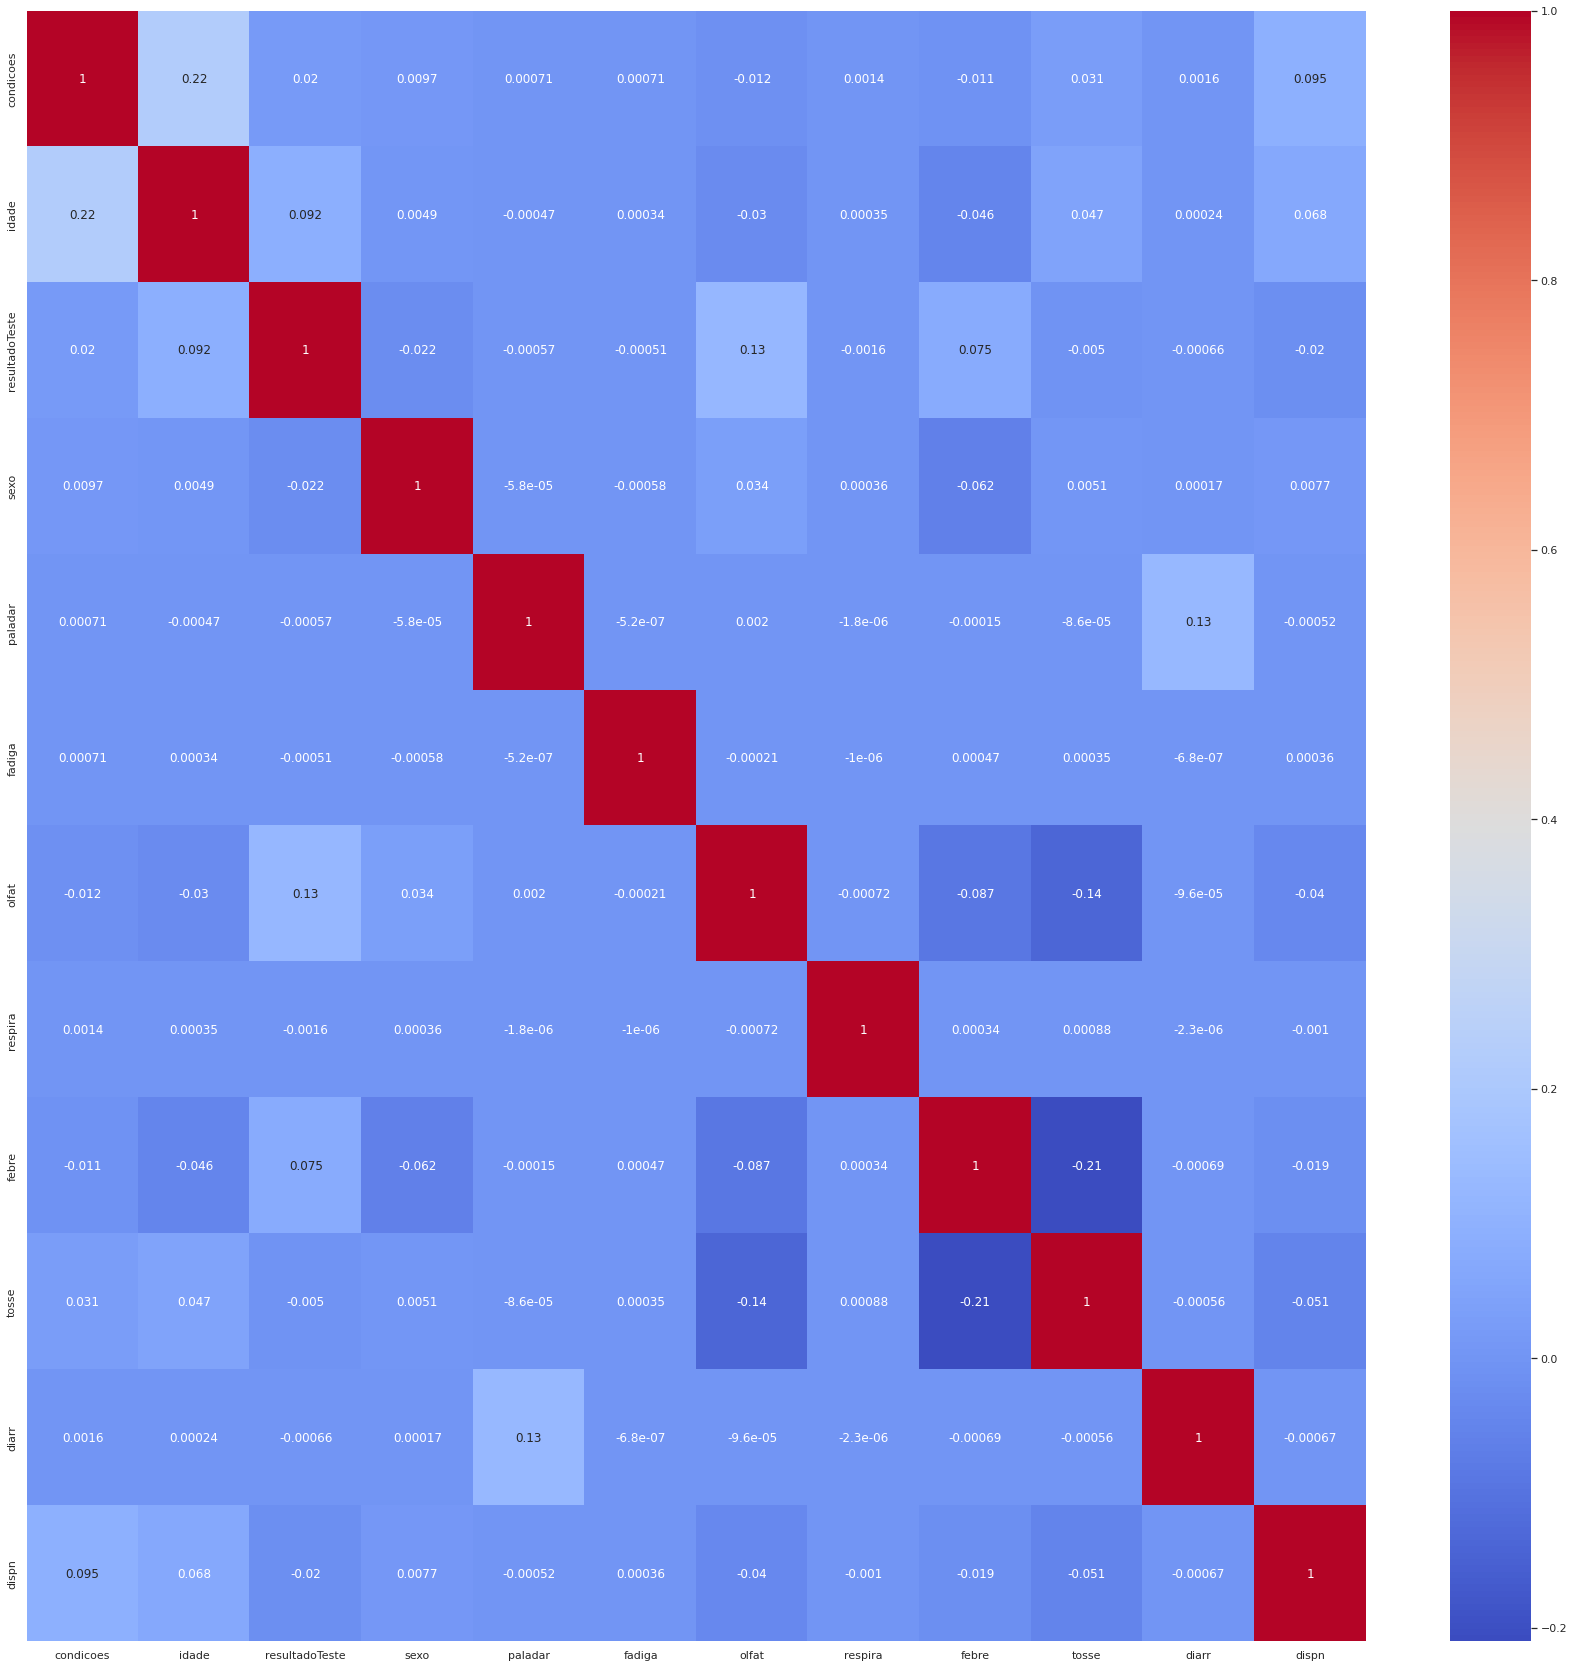

array([[<AxesSubplot:title={'center':'condicoes'}>,
        <AxesSubplot:title={'center':'idade'}>,
        <AxesSubplot:title={'center':'resultadoTeste'}>],
       [<AxesSubplot:title={'center':'sexo'}>,
        <AxesSubplot:title={'center':'paladar'}>,
        <AxesSubplot:title={'center':'fadiga'}>],
       [<AxesSubplot:title={'center':'olfat'}>,
        <AxesSubplot:title={'center':'respira'}>,
        <AxesSubplot:title={'center':'febre'}>],
       [<AxesSubplot:title={'center':'tosse'}>,
        <AxesSubplot:title={'center':'diarr'}>,
        <AxesSubplot:title={'center':'dispn'}>]], dtype=object)

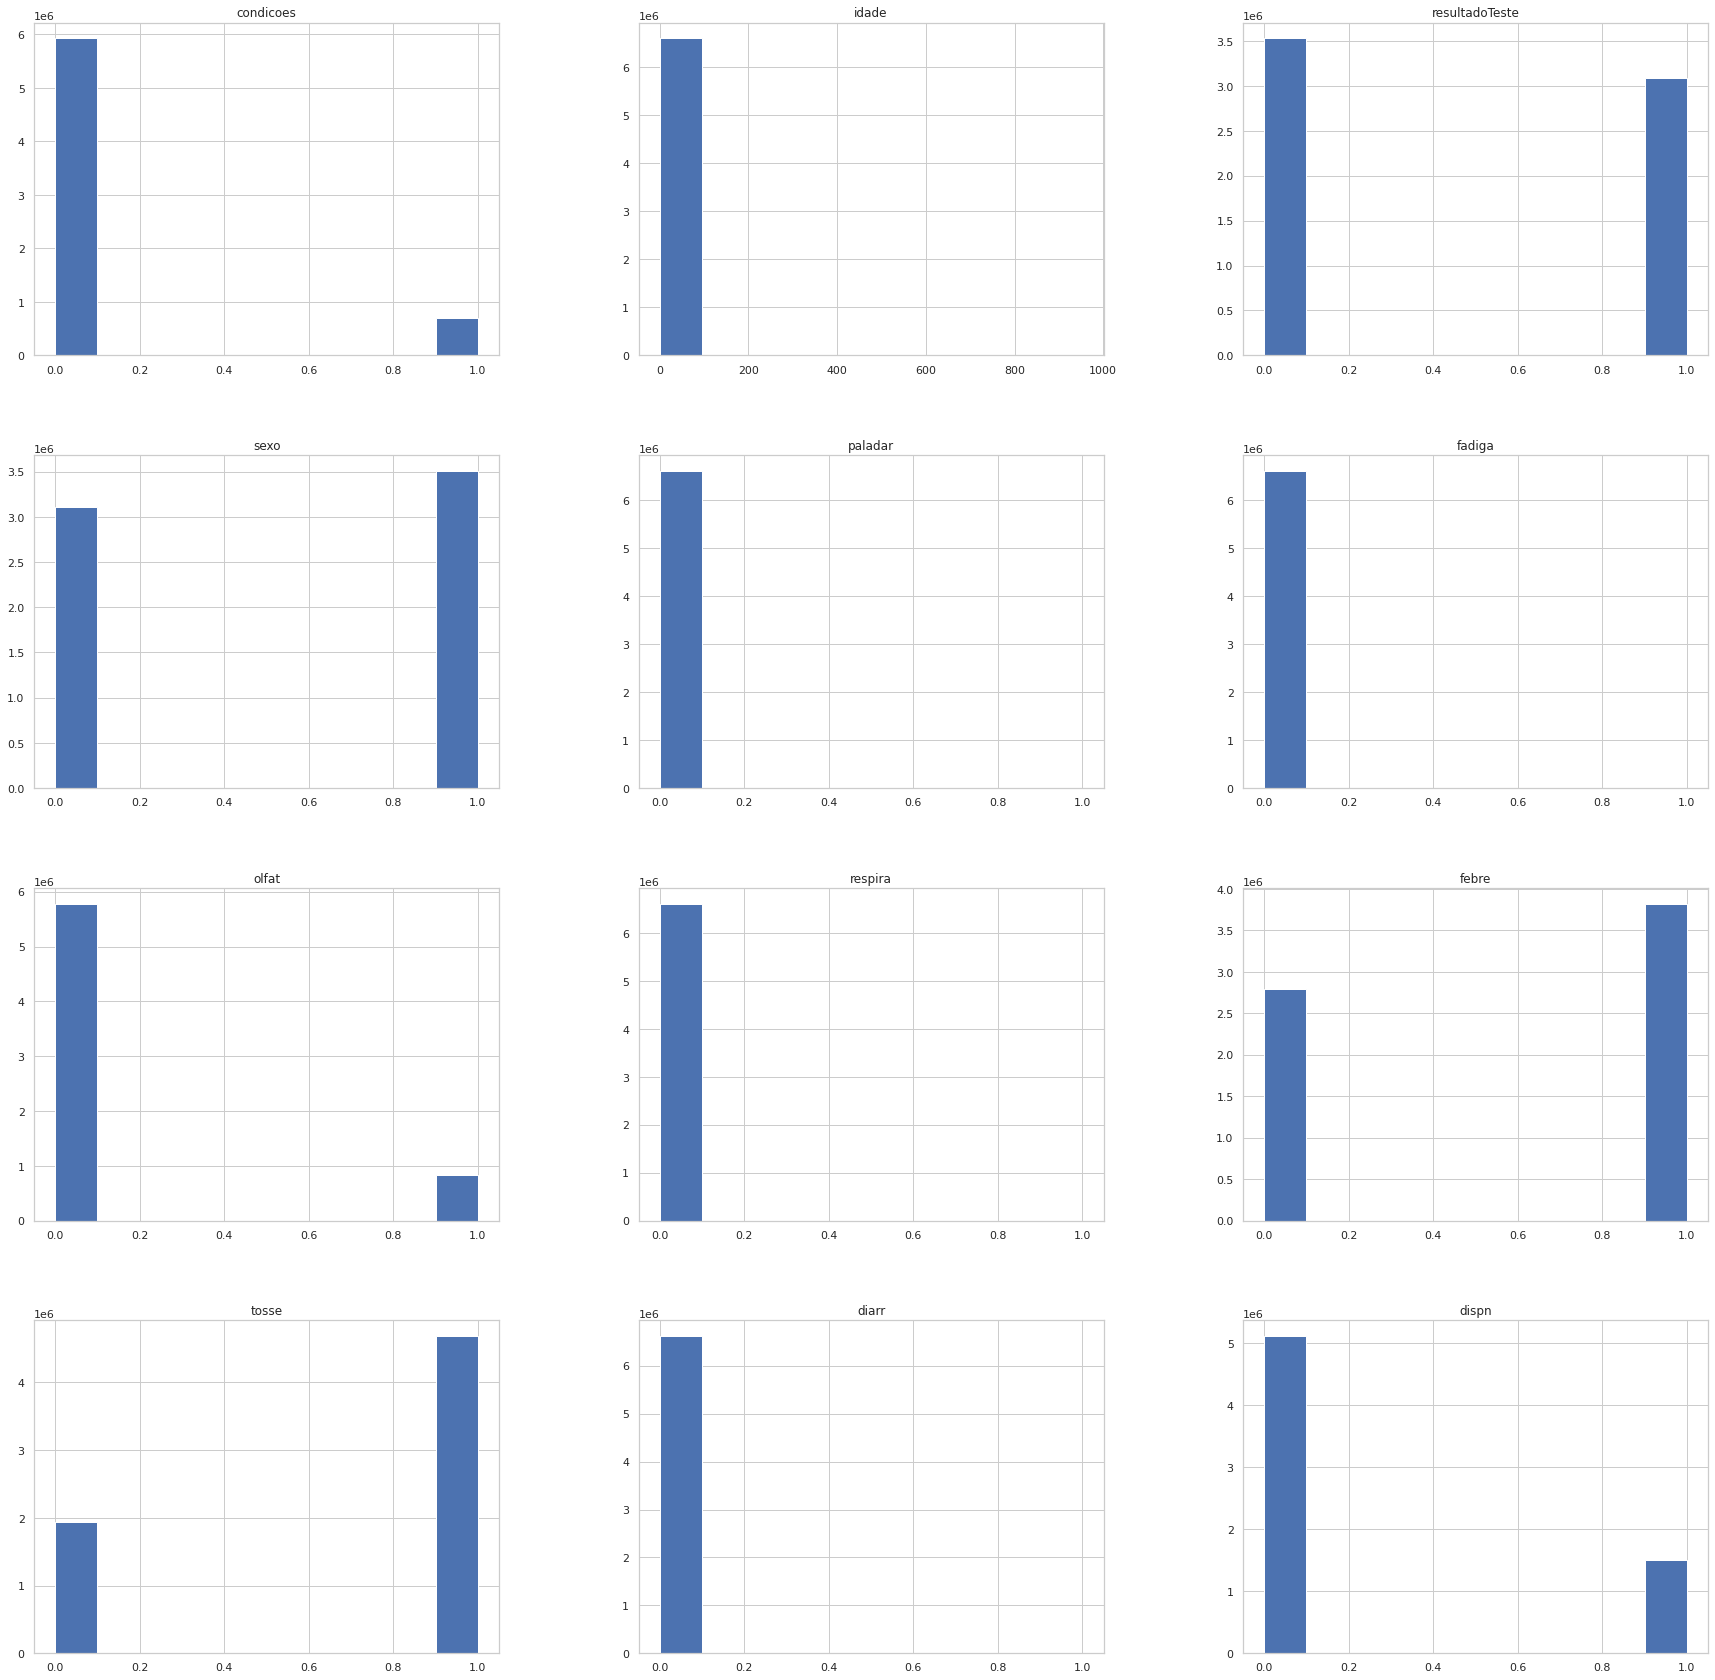

In [10]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
figure = plt.figure(figsize=(30,30))
sns.heatmap(baseDados.corr(),annot=True, cmap='coolwarm')
plt.show()
baseDados.hist(figsize=(30,30))

### Inserindo os dados no framework.

O fastai possui uma biblioteca grande com relação a machine learning e o pré-processamento deles costuma ser bem simples, a depender do conjunto de dados. Nessa parte definimos alguns pontos:
- Tamanho do conjunto de treino e teste em que foi divido em 80% e 20% respectivamente.
- Preecher dados faltantes e normalizar os dados (evitar que a idade que tem o range bem maior que os outros dados tenha muita influência)
- Definir variáveis categóricas e continuas. 
- Definir qual coluna deve ser considerada a saída do modelo. 

In [11]:
splits = RandomSplitter(valid_pct=0.2)(range_of(baseDados))

to = TabularPandas(
    baseDados,
    procs=[Categorify, FillMissing,Normalize],
    cat_names = ['condicoes', 'sexo', 'paladar', 'fadiga', 'olfat', 'respira', 'febre', 'dispn', 'diarr', 'tosse'],
    cont_names = ['idade'],
    y_names='resultadoTeste',
    splits=splits)
    
to.xs.iloc[:2]

,condicoes,sexo,paladar,fadiga,olfat,respira,febre,dispn,diarr,tosse,idade_na,idade
14817725,1,1,1,1,2,1,1,1,1,2,1,-0.269169
8464340,2,1,1,1,1,1,2,1,1,2,1,1.121558


In [12]:
dls = to.dataloaders(bs=64)

dls.show_batch()

,condicoes,sexo,paladar,fadiga,olfat,respira,febre,dispn,diarr,tosse,idade_na,idade,resultadoTeste
0,0,0,0,0,0,0,0,1,0,1,False,37.000000,1.0
1,0,1,0,0,0,0,1,1,0,1,False,58.999999,1.0
2,0,0,0,0,0,0,1,0,0,1,False,42.000000,1.0
3,0,0,0,0,0,0,0,0,0,1,False,31.000000,0.0
4,0,0,0,0,0,0,0,0,0,1,False,26.000000,1.0
5,0,1,0,0,0,0,1,1,0,0,False,23.000000,1.0
6,0,0,0,0,0,0,0,0,0,1,False,73.999999,0.0
7,0,1,0,0,0,0,1,0,0,1,False,30.000000,1.0
8,0,1,0,0,0,0,0,0,0,1,False,67.000001,0.0
9,0,1,0,0,0,0,0,0,0,1,False,54.000000,1.0


### Inicio do modelo e checagem do loss

Aqui é onde se inicia o modelo (tabular_learner) e a fim de checar o loss esse gráfico foi gerado. Foi usado para definir manualmente o learning_rate em alguns testes

SuggestedLRs(valley=0.0010000000474974513)

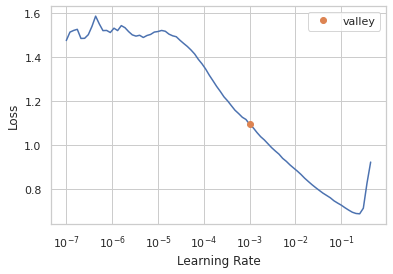

In [13]:
learn = tabular_learner(dls, metrics=accuracy)

learn.lr_find()

### Treinamento

Aqui é onde o modelo é efetivamente treinado. Nesse ultimo teste foi obtido acurácia de 53%. O loss do treinamento permanece a mesma média dos outros treinamentos, mas a acurácia girava em torno de 50% a 60%. Entretanto o modelo com maior acerto continha dados sem sintomas e assim o modelo tendia a responder mais negativo do que positivo. 

O modelo ainda tem como evoluir principalmente em relação aos dados. Uma das principais melhorias é definir se alguns dados possam estar atrapalhando o treinamento e também procurar os dados __outlines__. Outro ponto que pode gerar melhora é testar mais frameworks, como RandomForest, TnsorFlow, PyTorch entre outros. 

In [14]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.237145,0.237830,0.534047,15:52
